# NeedleMaster Dataset Example

Predict the needle position and orientation from an image

## Imports 
* pytorch_datasets for Dataset class, DataLoader
* tdqm for interactive loading bars 
* numpy for math 
* torch for deep learning library
* torchvision for deep learning vision library 
* multiprocessing to run on multiple cpus (if applicable)
* random to select random trials/frames in _get__item_, and to make random datasplits
* matplotlib for displaying image frames
* pdb (debugging)

In [16]:
import random 
import numpy as np
from tqdm import tqdm_notebook as tdqm
import multiprocessing
import matplotlib.pyplot as plt
from pdb import set_trace as woah

import torch
import torchvision
import pytorch_datasets

Code to set up the environment. Choose if the deep learning will run on the CPU or GPU. Initialize the torch random seed, and if using a GPU the GPU random seed. 

In [3]:
torch.manual_seed(random.randint(1, 10000))
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(DEVICE == "cuda"):
    torch.cuda.manual_seed(random.randint(1, 10000))
    # Disable nondeterministic ops (not sure if critical but better safe than sorry)
    torch.backends.cudnn.enabled = False  

## Introduction
This notebook is an example for using the Pytorch Datasets wrapper to write a data loader for the NeedleMaster dataset. 

* __NeedleMaster__ is an Android game developped by Chris Paxton (https://github.com/cpaxton/needle_master_tools.) Images from recorded demonstrations were rendered to create a toy dataset with images, needle poses, and user actions. This dataset is currently on a local directory. For information contact molly@jhu.edu. 


## Loading Data 

In [4]:
nm = pytorch_datasets.NeedleMaster('/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/', \
                                   train_split=None, transforms=None)

The attribute '_getitem_' can be used to load individual images and needle poses. The needle position is x/screen_width, y/screen_width, and theta/2_pi

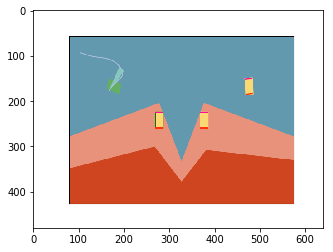

needle pose: [ 0.17842301  0.32555237  0.85363978]


In [5]:
sample = nm.__getitem__(idx=100, frame_idx=100)

plt.imshow(sample['image'])
plt.show()

print('needle pose: ' + str(sample['needle']))

In [6]:
def tensor_to_numpy_im(image):
    C, W, H = image.size()
    numpy_image = np.zeros((W, H, C))
    for c in range(C):
        numpy_image[:,:,c] = image[c,:,:].numpy()
    return numpy_image

## Model 
A pretrained resnet18 model is used with a final fully connected layer. The FC layer is used to regress the pose of the needle.

In [7]:
class Model(torch.nn.Module):
    """ Example Model. ResNet18 with a prediction layer on top. """
    def __init__(self, num_labels):
        super(Model, self).__init__()
        self.base_model = torch.nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1])
        base_model_fc_size = list(self.base_model.parameters())[-1].size(0)
        self.fc = torch.nn.Linear(base_model_fc_size, num_labels)
        self.sm = torch.nn.Softmax()
        
    def forward(self, images):
        im_features = self.base_model(images)
        preds = self.fc(im_features.squeeze())
        return preds

## Training Epoch
Code to do one epoch of training

In [35]:
def epoch(train_mode, description, model, dataloader, optimizer=None, loss_func=None):
    """ Train, validation, or test epoch """
    # Create dataset iterator
    iterator = tqdm(dataloader, ncols=115, desc=description)

    # Turn off batch norm, etc. during testing/validation
    model = model.train(train_mode)

    # Data to print
    running_losses, running_predict, running_x, running_y, running_w = [], [], [], [], []

    # Loop over all data
    with torch.set_grad_enabled(train_mode):
        for data in iterator:
            outputs = model(data['image'].to(DEVICE)) # Forward pass

            if train_mode:
                optimizer.zero_grad() # Zero out gradients
                loss = loss_func(outputs.double(), torch.cuda.DoubleTensor(data['needle'].to(DEVICE)))
                running_losses.append(loss.item())
                loss.backward()
                optimizer.step()

            # Update labels and predictions
            prediction = outputs.cpu().detach().numpy()
            running_predict.extend(prediction)

            # Update accuracy
            error_x     = np.mean(abs(data["needle"].numpy()[:,0] - prediction[:,0]))
            error_y     = np.mean(abs(data["needle"].numpy()[:,1] - prediction[:,1]))
            error_w     = np.mean(abs(data["needle"].numpy()[:,2] - prediction[:,2]))
            running_x.append(error_x); running_y.append(error_y); running_w.append(error_w)
                          
#             info_to_show = {'Error x': "{:.4f}".format(error_x)}
            
#             if train_mode:
#                 info_to_show['Loss'] = "{:.5f}".format(np.mean(running_losses))
#             iterator.set_postfix(info_to_show)
    
    return running_losses, running_predict, running_x, running_y, running_w

## main 

In [36]:
# Create image tranforms
transforms_train = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomCrop((224, 224)),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(.2, .2, .2, .2), 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.]),
    
])
transforms_test = torchvision.transforms.Compose([
    #torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

# Create datasets
root = '/home/molly/workspace/Surgical_Automation/experiments/needle_master_tools/'
dataset_train = pytorch_datasets.NeedleMaster(root, train_split=None, transforms=transforms_train)

# Create dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True,  batch_size=256, num_workers=multiprocessing.cpu_count())

# Create Model
regress_dim = 3
model = Model(regress_dim).to(DEVICE)

# Create loss function and optimizer
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.0001)
loss_func = torch.nn.MSELoss().to(DEVICE)

# Train + Val
Loss, Error_x, Error_y, Error_w = [], [], [], []
num_epochs = 20
for epoch_idx in range(num_epochs):
    loss, pred, e_x, e_y, e_w = epoch(True, "Training", model, dataloader_train, optimizer, loss_func)
    Loss.extend(loss); Error_x.extend(e_x); Error_y.extend(e_y); Error_w.extend(e_w)
    #epoch(False, "Validating", model, dataloader_val)
    print("Epoch: " + str(epoch_idx) + "    Loss: "+ "%1.2f" % np.mean(loss) +"\t Error_x: "+ "%1.2f" % np.mean(e_x) , end='\r')
# Test
#epoch(False, "Testing", model, dataloader_test)



Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]

Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.09s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.04s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.04s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.07s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.13s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.13s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.04s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.08s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.07s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.06s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.05s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.09s/it]

Training:   0%|                                                                              | 0/2 [00:00<?, ?it/s]



Training:  50%|███████████████████████████████████                                   | 1/2 [00:04<00:04,  4.07s/it]

Training: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.10s/it]

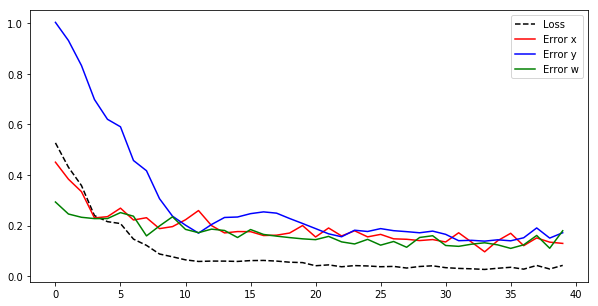

In [37]:
fig = plt.figure(figsize=(10,5))
plt.plot(Loss, 'k--', label='Loss')
plt.plot(Error_x, c='r', label='Error x')
plt.plot(Error_y, c='b', label='Error y')
plt.plot(Error_w, c='g', label='Error w')
plt.legend()
plt.show()

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/

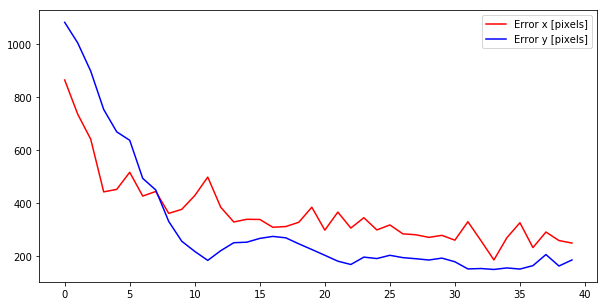

  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
BrokenPipeError: [Errno 32] Broken pipe


In [38]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.multiply(Error_x, 1920.0), c='r', label='Error x [pixels]')
plt.plot(np.multiply(Error_y, 1080.0), c='b', label='Error y [pixels]')
# plt.plot(Error_w*2*3.1415, c='g', label='Error w [radians]')
plt.legend()
plt.show()

# About this notebook
Created on 2/13/2019. Original code from surgical_activity_recognition.py by Mike Peven. Modified by Molly O'Brien. 

# Footer 